In [1]:
import django
import pandas as pd
import requests
django.setup()

In [2]:
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

from sch.models import *
import datetime as dt
from django.db.models import CharField
from django.db.models.functions import Cast
from django.test import RequestFactory
from sch.actions import *
from sch.views2 import *
from django.db.models import Sum

In [3]:
josh_op = Slot.objects.filter(employee__name='Josh',shift__name='OP')
print([op.workday.days_away for op in josh_op])

[]


In [4]:
tallies = tally(list(Slot.objects.filter(shift__name="OP").values_list('employee__name',flat=True)))
df = pd.DataFrame.from_dict(sortDict(tallies,reverse=True), orient='index', columns=['count'])
df

,count
Brittanie,195
Leslie,17
None,5


<AxesSubplot:>

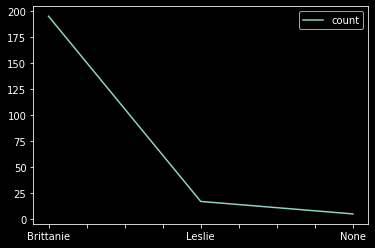

In [5]:
df.plot()

In [6]:
sch = Schedule.objects.first()

empls = Employee.objects.annotate(scheduleHours=Sum('slots__shift__hours')).order_by('-scheduleHours')
# standard schedule Hours should be 240 * the employees fte field
empls = empls.annotate(standardScheduleHours=240*F('fte'))
empls = empls.annotate(percentScheduled=F('scheduleHours')/F('standardScheduleHours')*100)
data = empls.values('name','scheduleHours','standardScheduleHours','percentScheduled')
df = pd.DataFrame.from_records(data)
df

,name,scheduleHours,standardScheduleHours,percentScheduled
0,Danica,1860.0,240.0,775.000000
1,Brianna A,1760.0,240.0,733.333333
2,Esperanza,1690.0,240.0,704.166667
3,Mona,1580.0,240.0,658.333333
4,Brittanie,1560.0,240.0,650.000000
5,Amanda,1510.0,210.0,719.047619
6,Jaden,1500.0,240.0,625.000000
7,Michael,1430.0,210.0,680.952381
8,Cheryl,1340.0,240.0,558.333333
9,Elisia,1330.0,240.0,554.166667


In [7]:
def sch_solve_with_lookbehind (request, schid):
    sch = Schedule.objects.get(slug=schid)
    success_bucket = []
    emptySlots = sch.slots.empty().order_by('?')
    for slot in emptySlots:
        if slot.workday.sd_id != 0:
            prev = slot.workday.prevWD().slots.filter(shift__start__hour__lte=slot.shift.start.hour+1, shift__start__hour__gte=slot.shift.start.hour-1)
            choices = []
            for p in prev:
                if p.streak < p.employee.streak_pref and p.employee not in choices and p.employee in slot.workday.on_deck():
                    choices.append(p.employee)
            if len(choices) > 0:
                chosen = random.choice(choices)
                if PtoRequest.objects.filter(employee=chosen, workday=slot.workday.date).exists() == False:
                    if TemplatedDayOff.objects.filter(employee=chosen, sd_id=slot.workday.sd_id).exists() == False:
                        try:
                            slot.employee = chosen
                            slot.save()
                            success_bucket.append(slot)
                        except:
                            print(f"ERROR: {slot} could not be filled")
                    else: 
                        print(f"{chosen} has a templated day off on {slot.workday.date}")
                else:
                    print(f"{chosen} has a PTO request on {slot.workday.date}")
            else:
                print(f"No choices for {slot}")
                try:
                    slot.employee = random.choice(workday.on_deck())
                    slot.save()
                    success_bucket.append(slot)
                except:
                    print(f"ERROR: Backup Fill via On Deck Employees Failed. This slot was not filled. {slot}")
        else:
            print(f"{slot} is on First Sunday of Schedule")
    print(len(success_bucket) , "slots filled via method SCHEDULE_SOLVE_WITH_LOOKBEHIND")
                    

In [8]:
def emusr_distr (request, schId):
    sch = Schedule.objects.get(slug=schId)
    print (f"SCHEDULE: {sch}")
    n_pm = sch.slots.evenings().count()
    print (f"# EVENING SHIFTS: {n_pm}")
    pm_empls = Employee.objects.filter(
        time_pref__in=["PM", "XN"]
    )
    pm_empls_shifts = sum(list(pm_empls.values_list("fte", flat=True))) * 40 * 6
    print (f"{pm_empls_shifts} HRS OF EVENING SHIFTS FILLED BY PM EMPLOYEES")
    remaining_pm = n_pm - pm_empls_shifts
    full_template_empls = Employee.objects.full_template_employees().values("pk")
    am_empls_fte_sum = sum(
        list(
            Employee.objects.filter(time_pref__in=["AM"])
            .exclude(pk__in=full_template_empls)
            .values_list("fte", flat=True)
        )
    )
    print (f'{am_empls_fte_sum}   TOTAL-FTE OF MORNING EMPLOYEES')
    unfavorables = sch.slots.unfavorables().values("employee")
    unfavorables = unfavorables.annotate(
        count=Value(1, output_field=IntegerField())
    )
    unfavorables = unfavorables.values("employee").annotate(count=Sum("count"))
    print (f"{unfavorables.values('employee__name','count')} UNFAVORABLES")
    emusr_differences = list(unfavorables.values_list("count", flat=True))
    while None in emusr_differences:
        emusr_differences.remove(None)
        emusr_differences.append(0)
    if len(emusr_differences) == 0:
        emusr_differences.append(0)
    return max(emusr_differences) - min(emusr_differences)

In [9]:
emusr_distr (None, '2023-S1A')

SCHEDULE: 2023-S1A
# EVENING SHIFTS: 151
1260.0 HRS OF EVENING SHIFTS FILLED BY PM EMPLOYEES
6.0   TOTAL-FTE OF MORNING EMPLOYEES
<SlotManager [{'employee__name': 'Brianna A', 'count': 2}, {'employee__name': 'Cheryl', 'count': 7}, {'employee__name': 'David', 'count': 5}, {'employee__name': 'Elisia', 'count': 2}, {'employee__name': 'Esperanza', 'count': 1}, {'employee__name': 'Jaden', 'count': 5}, {'employee__name': 'Mandy', 'count': 6}, {'employee__name': 'Mark', 'count': 2}, {'employee__name': 'Sabrina', 'count': 2}, {'employee__name': 'Teddy', 'count': 2}]> UNFAVORABLES


6

In [19]:
from django.db.models import Count, OuterRef, Subquery

# define a subquery that counts the occurrences of each employee/shift combination in the Slot model
subquery = Subquery(
    Slot.objects.filter(
        employee=OuterRef('employee'),
        shift=OuterRef('shift')
    ).values('employee', 'shift').annotate(
        count=Count('*')
    ).values('count')[:1],
    output_field=models.IntegerField()
    )


# Count n of Slots, then if A ShiftPreference exists for that employee/shift combination
j = Employee.objects.get(name='Sabrina')
j_shift_prefs = j.shift_prefs.annotate(count=subquery)

score_subquery = Subquery(
    Slot.objects.filter(
        employee=OuterRef('employee'),
        shift=OuterRef('shift'),
    ).values('employee', 'shift', 'employee__shift_prefs__priority').annotate(
        count=Count('*')
    ).values('count')[:1],
    output_field=models.IntegerField()
)
from django.db.models import Sum

j_shift_prefs_with_counts = j_shift_prefs.annotate(
    pref_score=Subquery(
        ShiftPreference.objects.filter(
            employee=OuterRef('employee'),
            shift=OuterRef('shift')
        ).values('score')[:1]
    )
).annotate(
    score_count=Coalesce(score_subquery, 0)
).values(
    'score'
).annotate(
    count=Sum('score_count')
).order_by('score')


([<matplotlib.axis.XTick at 0x7f7a232fc820>,
 [Text(-3, 0, 'Dislike'), Text(0, 0, 'Neutral'), Text(3, 0, 'Prefer')])

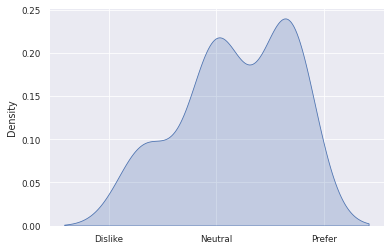

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
data = []
for j in j_shift_prefs_with_counts:
    for n in range(j['count']):
        data.append(j['score'])

sns.kdeplot(data=data, fill=True, bw_adjust=1.5)
sns.set_theme('paper',"darkgrid")
# change x label to "Dislike" at -3 and "Prefer" at 3
plt.xticks([-3, 0, 3], ['Dislike', 'Neutral', 'Prefer'])